In [35]:
%matplotlib inline

# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

## Origin

This notebook commes from long line of predecessors. Its origin can be traced back to [IA161: Advanced NLP Course](https://nlp.fi.muni.cz/en/AdvancedNlpCourse/MachineTranslation#PracticalSession), [seq2seq_translation_tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) and [Sean Robertson](https://github.com/spro/practical-pytorch>).

## Improvements

So what is new compared to presious versions?
- Minor changes in descripstions and formating.
- Doing Czech to English translation (previous versions did just French to English).


## Goal

In this notebook, we will be teaching a neural network to translate from French and Czech to English:

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.



## Basic idea

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

All words are represented by numbers, because neural network works only with numbers. We have mapping between words and numbers outside of a network.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Decoder is presented with one token at a time on input. It takes this token and inner state to predict following token in a sentence. First input token is a start_of_sentence `<SOS>` token. Each predicted output token is then used as next input token for decoder. When decoder generated end_of_sentence `<EOS>` token, whole translation stops.

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.



## Recommended Reading

Installation of PyTorch, knowledge of Python and understanding of Tensors is required:


-  https://pytorch.org/ For installation instructions
-  [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to get started with PyTorch in general
-  [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) for a wide and deep overview
-  [PyTorch for Former Torch Users](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
-  [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
-  [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

Pytorch is also providing tutorials for concempts that are very similar to the Encoder and Decoder models:

- [NLP From Scratch: Classifying Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
- [NLP From Scratch: Generating Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

# Setup

## Packages

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data files


The data for this notebook will be two sets:
- English to French translation pairs and 
- Czech to English translation pairs

The English to French pairs file is a tab separated list of translation pairs:

```
I am cold.    J'ai froid.
```

The Czech to English pairs are to files with alligned sentences:

```
Tady je další!    Here's another one!
```



### English to French

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-11-20 12:42:44--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.49, 52.85.79.72, 52.85.79.74, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2021-11-20 12:42:44 (39.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

Splitting eng-fra file into two files so we have the same structure as cz-eng dataset.

In [4]:
!cut -f 1 data/eng-fra.txt  > engfra.en
!cut -f 2 data/eng-fra.txt  > engfra.fr

### Czech to English

Czech and English training files have 2.7G and 2.6G, downloading takes a few minutes.

In [5]:
!wget https://nlp.fi.muni.cz/projekty/ficet-czeng/nmt-data-download/czeng20-train.cs
!wget https://nlp.fi.muni.cz/projekty/ficet-czeng/nmt-data-download/czeng20-train.en

--2021-11-20 12:42:45--  https://nlp.fi.muni.cz/projekty/ficet-czeng/nmt-data-download/czeng20-train.cs
Resolving nlp.fi.muni.cz (nlp.fi.muni.cz)... 147.251.51.11
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2852927998 (2.7G)
Saving to: ‘czeng20-train.cs’

czeng20-train.cs    100%[===================>]   2.66G  23.4MB/s    in 1m 56s  

2021-11-20 12:44:41 (23.4 MB/s) - ‘czeng20-train.cs’ saved [2852927998/2852927998]

--2021-11-20 12:44:42--  https://nlp.fi.muni.cz/projekty/ficet-czeng/nmt-data-download/czeng20-train.en
Resolving nlp.fi.muni.cz (nlp.fi.muni.cz)... 147.251.51.11
Connecting to nlp.fi.muni.cz (nlp.fi.muni.cz)|147.251.51.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2718346801 (2.5G)
Saving to: ‘czeng20-train.en’

czeng20-train.en    100%[===================>]   2.53G  23.5MB/s    in 1m 51s  

2021-11-20 12:46:33 (23.4 MB/s) - ‘czeng20-train.en’ saved [27

In [6]:
!head -n500000 czeng20-train.cs > czeng.cs
!head -n500000 czeng20-train.en > czeng.en

# Data preparation

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

![](https://pytorch.org/tutorials/_images/word-encoding.png)



We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called `Lang` which has word → index (`word2index`) and index → word
(`index2word`) dictionaries, as well as a count of each word
`word2count` which will be used to replace rare words later.




In [7]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.

Normalization to make proprocessing easier and faster.




In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [9]:
def readLangs(lang1, lang1_file, lang2, lang2_file, reverse=False):
    print("Reading pairs...")

    # Read the files and split into lines
    lang1_lines = open(lang1_file, encoding='utf-8').\
        read().strip().split('\n')
    lang2_lines = open(lang2_file, encoding='utf-8').\
        read().strip().split('\n')

    # Put language lines into pairs
    pairs = [[normalizeString(lang1_line), normalizeString(lang2_line)] for lang1_line, lang2_line in zip(lang1_lines, lang2_lines)]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).

We have only sentences in this form "I am ..." - training for this type of data is quicker.




In [10]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [11]:
def prepareData(lang1, lang1_file, lang2, lang2_file, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang1_file, lang2, lang2_file, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
input_freng, output_freng, pairs_freng = prepareData('eng', 'engfra.en', 'fra', 'engfra.fr', True)
print(random.choice(pairs_freng))

Reading pairs...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['ils sont tous mauvais .', 'they re all bad .']


In [13]:
input_czeng, output_czeng, pairs_czeng = prepareData('eng', 'czeng.en', 'cz', 'czeng.cs', True)
print(random.choice(pairs_czeng))

Reading pairs...
Read 500000 sentence pairs
Trimmed to 11737 sentence pairs
Counting words...
Counted words:
cz 8630
eng 5578
['je mi to lito phuong .', 'i m sorry phuong .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




## The Encoder


The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](https://pytorch.org/tutorials/_images/encoder-network.png)

Input is word encoded as one-hot vector with length of lexicon. We use embedding layer to map one-hot vector to some shorter vector with real numbers. 





In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    # this computation corresponds to presented graph of the encoder
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

![](https://pytorch.org/tutorials/_images/decoder-network.png)

input: previous word.  
output: statistical probility of words on output. 




In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    # this computation corresponds to presented graph of the decoder
    # variable 'output' is used for intermediate calculations in the left part of graph
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder


If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![](https://i.imgur.com/1152PYf.png)

For each of input tokens, prepare scores how they are important for decoding current token. 

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

Bottom part is the same as in previous picture of decoder. But input are prev_hidden are changed. 
Attention is of size of hidden layer (I think). They are combined with encoder_outputs.



In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    # this is slightly more complicated, but computation still corresponds to presented graph of the attention decoder
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


# Training



## Preparing Training Data


To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.


In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training the Model


To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. We don't need outputs for simple decoder without attention, but we need them when we are using attention, to apply attention to outputs. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [18]:
teacher_forcing_ratio = 0.5

# training of one sentecnce
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # initialization of hidden layer of encoder
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # encoder part
    # for each token, we run encoder and record the hidden vector of the encoder for later processes
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # input is the start_of_sentence token
    decoder_input = torch.tensor([[SOS_token]], device=device)
    # first hidden layer is the last hidden vector of encoder
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # for each workd we run one step of decoder
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # target_tensor contains words we expect on output
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # at the end of sequence - backward propagation of error, computes (..)
    loss.backward()

    # updates parameters accordint to computed (..)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [20]:
def trainIters(encoder, decoder, n_iters, input_lang, output_lang, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [21]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [22]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [23]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU (or 30 minutes on Colab with GPU) we'll get some reasonable results.

_**Note:**
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again._




## French to English

In [24]:
hidden_size = 256
encoder_freng = EncoderRNN(input_freng.n_words, hidden_size).to(device)
attn_decoder_freng = AttnDecoderRNN(hidden_size, output_freng.n_words, dropout_p=0.1).to(device)
pairs = pairs_freng

trainIters(encoder_freng, attn_decoder_freng, 75000, input_lang=input_freng, output_lang=output_freng, print_every=5000)

2m 12s (- 31m 0s) (5000 6%) 2.8566
4m 19s (- 28m 9s) (10000 13%) 2.2896
6m 25s (- 25m 42s) (15000 20%) 1.9498
8m 31s (- 23m 26s) (20000 26%) 1.7183
10m 37s (- 21m 15s) (25000 33%) 1.5214
12m 43s (- 19m 5s) (30000 40%) 1.3174
14m 49s (- 16m 56s) (35000 46%) 1.1823
16m 56s (- 14m 49s) (40000 53%) 1.0707
19m 3s (- 12m 42s) (45000 60%) 0.9942
21m 10s (- 10m 35s) (50000 66%) 0.8971
23m 17s (- 8m 28s) (55000 73%) 0.8211
25m 24s (- 6m 21s) (60000 80%) 0.7485
27m 32s (- 4m 14s) (65000 86%) 0.6543
29m 41s (- 2m 7s) (70000 93%) 0.6000
31m 48s (- 0m 0s) (75000 100%) 0.5637


In [25]:
evaluateRandomly(encoder_freng, attn_decoder_freng, input_freng, output_freng)

> je n ai pas peur des fantomes .
= i m not afraid of ghosts .
< i m not afraid of ghosts . <EOS>

> nous sommes differents .
= we re different .
< we re different . <EOS>

> ce n est pas toi qui dirige .
= you re not in charge .
< you re not in charge . <EOS>

> tu es nerveusement usee .
= you re a nervous wreck .
< you re a nervous wreck . <EOS>

> je vais devenir avocat .
= i m going to be a lawyer .
< i m going to be your lawyer . <EOS>

> vous etes givrees !
= you re nuts !
< you re nuts ! <EOS>

> je suis egoiste .
= i m selfish .
< i m selfish . <EOS>

> elle n est pas tout a fait satisfaite .
= she is not quite content .
< she s not quite all . <EOS>

> je ne crains personne .
= i m not scared of anybody .
< i m not scared of anybody . <EOS>

> il est ivre .
= he is drunk .
< he is drunk . <EOS>



## Czech to English

In [26]:
hidden_size = 256
encoder_czeng = EncoderRNN(input_czeng.n_words, hidden_size).to(device)
attn_decoder_czeng = AttnDecoderRNN(hidden_size, output_czeng.n_words, dropout_p=0.1).to(device)
pairs = pairs_czeng

trainIters(encoder_czeng, attn_decoder_czeng, 75000, input_lang=input_czeng, output_lang=output_czeng, print_every=5000)

2m 11s (- 30m 35s) (5000 6%) 3.1697
4m 15s (- 27m 40s) (10000 13%) 2.7159
6m 20s (- 25m 20s) (15000 20%) 2.4821
8m 25s (- 23m 9s) (20000 26%) 2.2859
10m 31s (- 21m 2s) (25000 33%) 2.1495
12m 37s (- 18m 55s) (30000 40%) 2.0168
14m 43s (- 16m 49s) (35000 46%) 1.8964
16m 49s (- 14m 43s) (40000 53%) 1.7851
18m 56s (- 12m 37s) (45000 60%) 1.6877
21m 2s (- 10m 31s) (50000 66%) 1.5843
23m 7s (- 8m 24s) (55000 73%) 1.5136
25m 12s (- 6m 18s) (60000 80%) 1.4097
27m 18s (- 4m 12s) (65000 86%) 1.3594
29m 26s (- 2m 6s) (70000 93%) 1.2921
31m 33s (- 0m 0s) (75000 100%) 1.1912


In [27]:
evaluateRandomly(encoder_czeng, attn_decoder_czeng, input_czeng, output_czeng)

> budu se s nim muset setkat .
= i m gonna need to meet him .
< i m gonna meet him him him . <EOS>

> jenom zertuji frede .
= i m just kidding fred .
< i m just worried . <EOS>

> jsem urcite hetero .
= i m definitely straight .
< i m definitely straight . <EOS>

> je to mesias .
= he s the messiah .
< he s a . . <EOS>

> musi vypadat dobre v televizi .
= he s gotta look good on television .
< he s gotta on good on s . <EOS>

> jste pripraven za me zemrit ?
= you re ready to die for me ?
< you re to to die for me ? <EOS>

> ty jsi zmetek .
= you re an asshole .
< you re an asshole . <EOS>

> ja si nedelam srandu .
= i m not making fun .
< i m not kidding . <EOS>

> neni zac .
= you re welcome .
< you re welcome . <EOS>

> za to se omlouvam .
= i m sorry about that .
< i m sorry about what that . <EOS>



Train a little more, czech seems to be more complicated than french.

2m 15s (- 31m 37s) (5000 6%) 1.1487
4m 22s (- 28m 25s) (10000 13%) 1.0764
6m 28s (- 25m 53s) (15000 20%) 1.0296
8m 33s (- 23m 32s) (20000 26%) 0.9449
10m 38s (- 21m 16s) (25000 33%) 0.8687
12m 42s (- 19m 3s) (30000 40%) 0.8576
14m 46s (- 16m 53s) (35000 46%) 0.7980
16m 52s (- 14m 45s) (40000 53%) 0.7463
18m 58s (- 12m 39s) (45000 60%) 0.7143
21m 5s (- 10m 32s) (50000 66%) 0.6999
23m 11s (- 8m 26s) (55000 73%) 0.6443
25m 19s (- 6m 19s) (60000 80%) 0.6102
27m 27s (- 4m 13s) (65000 86%) 0.6159
29m 35s (- 2m 6s) (70000 93%) 0.5561
31m 43s (- 0m 0s) (75000 100%) 0.5377


<Figure size 432x288 with 0 Axes>

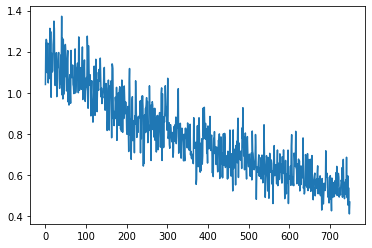

In [41]:
trainIters(encoder_czeng, attn_decoder_czeng, 75000, input_lang=input_czeng, output_lang=output_czeng, print_every=5000)

In [43]:
evaluateRandomly(encoder_czeng, attn_decoder_czeng, input_czeng, output_czeng)

> je o hlavu mensi nez ty .
= he s half your size .
< she s half your size . <EOS>

> delate si srandu .
= you re kidding .
< you re kidding . <EOS>

> jsi zraneny .
= you re hurt .
< you re hurt . <EOS>

> to ti nezereme .
= we re not buying it .
< we re not buying it . <EOS>

> vedes si skvele .
= you re doing great .
< you re doing great . <EOS>

> je to vnimavy muz .
= he s a perceptive man .
< he s a perceptive man . <EOS>

> jsou zoufali .
= they are desperate .
< they are desperate . <EOS>

> vite jsme kazdy jiny .
= we re all different you know .
< we re all different you know . <EOS>

> neni zac .
= you re welcome .
< you re welcome . <EOS>

> opravdu se snazim co to jen jde .
= i am trying my best .
< i m trying trying to do . <EOS>



# Comparison

Both models were trained in Colab with GPU



### Fr-En translation

Number of sentence pairs:

`10 599`

Train time: 

`31m 48s`

Final loss:

`0.5637`

Evaluate Random:

```
> je n ai pas peur des fantomes .
= i m not afraid of ghosts .
< i m not afraid of ghosts . <EOS>

> nous sommes differents .
= we re different .
< we re different . <EOS>

> ce n est pas toi qui dirige .
= you re not in charge .
< you re not in charge . <EOS>

> tu es nerveusement usee .
= you re a nervous wreck .
< you re a nervous wreck . <EOS>

> je vais devenir avocat .
= i m going to be a lawyer .
< i m going to be your lawyer . <EOS>

> vous etes givrees !
= you re nuts !
< you re nuts ! <EOS>

> je suis egoiste .
= i m selfish .
< i m selfish . <EOS>

> elle n est pas tout a fait satisfaite .
= she is not quite content .
< she s not quite all . <EOS>

> je ne crains personne .
= i m not scared of anybody .
< i m not scared of anybody . <EOS>

> il est ivre .
= he is drunk .
< he is drunk . <EOS>

```

### Cz-En translation

Number of sentence pairs:

`11737`

Train time: 

`31m 33s + 31m 43s`

Final loss:

`0.5377`

Evaluate Random:

```
> je o hlavu mensi nez ty .
= he s half your size .
< she s half your size . <EOS>

> delate si srandu .
= you re kidding .
< you re kidding . <EOS>

> jsi zraneny .
= you re hurt .
< you re hurt . <EOS>

> to ti nezereme .
= we re not buying it .
< we re not buying it . <EOS>

> vedes si skvele .
= you re doing great .
< you re doing great . <EOS>

> je to vnimavy muz .
= he s a perceptive man .
< he s a perceptive man . <EOS>

> jsou zoufali .
= they are desperate .
< they are desperate . <EOS>

> vite jsme kazdy jiny .
= we re all different you know .
< we re all different you know . <EOS>

> neni zac .
= you re welcome .
< you re welcome . <EOS>

> opravdu se snazim co to jen jde .
= i am trying my best .
< i m trying trying to do . <EOS>
```

# Visualizing Attention


A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




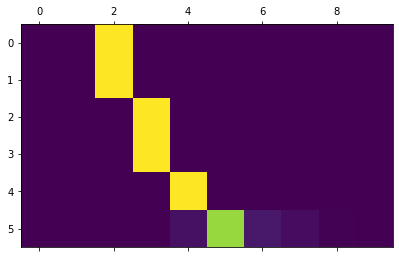

In [36]:
output_words, attentions = evaluate(
    encoder_czeng, attn_decoder_czeng, "ty jsi zmetek .", input_czeng, output_czeng)
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = ty jsi zmetek .
output = you re an asshole . <EOS>


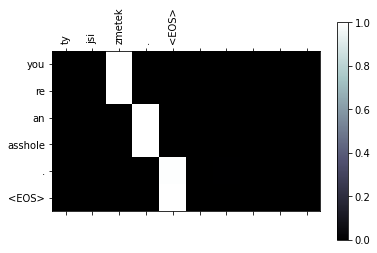

input = vite jsme kazdy jiny .
output = we re all different you know . <EOS>


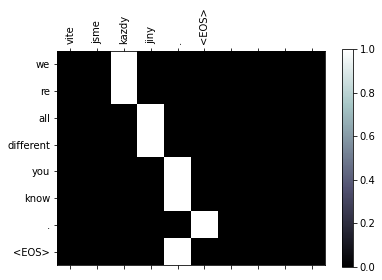

input = ja si nedelam srandu .
output = i m not gonna with . . <EOS>


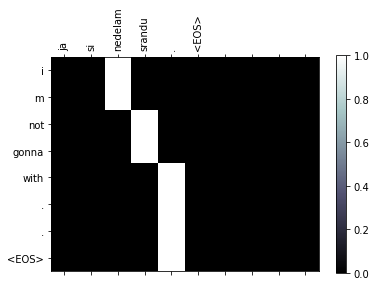

input = je o hlavu mensi nez ty .
output = she s half your size . <EOS>


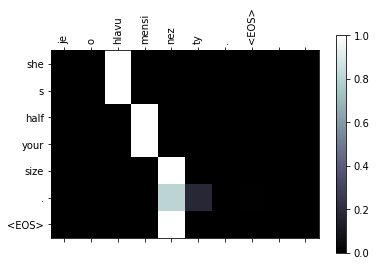

In [44]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder_czeng, attn_decoder_czeng, input_sentence, input_czeng, output_czeng
    )
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("ty jsi zmetek .")
evaluateAndShowAttention("vite jsme kazdy jiny .")
evaluateAndShowAttention("ja si nedelam srandu .")
evaluateAndShowAttention("je o hlavu mensi nez ty .")